In [178]:
import pandas as pd
import csv, datetime
import numpy as np
import xgboost as xgb
import fastai as fast
from sklearn.metrics import *
from sklearn.feature_selection import SelectFromModel
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Performing grid search
from sklearn.model_selection import train_test_split

#Scoring Function Based on combined adjusted AUC and adjusted Kappa
def scoreFunc(y_test, preds):
    rocAUC = roc_auc_score(y_test, preds)
    print('AUC: ' + str(rocAUC))
    roundedPreds = preds.round()
    Kappa = cohen_kappa_score(y_test,roundedPreds)

    AdjAUC = (rocAUC - 0.5) * 2 if (rocAUC>0.5) else 0
    print('AdjustedAUC: ' + str(AdjAUC))
    AdjKappa = Kappa if (Kappa > 0) else 0
    print('Kappa: ' + str(Kappa))
    print('AdjustedKappa: ' + str(AdjKappa))
    return AdjAUC + AdjKappa

#Scoring Function Based on combined adjusted AUC and adjusted Kappa
def evalFunc(preds, y_test):
    y_labels = y_test.get_label()
    rocAUC = roc_auc_score(y_labels, preds)
    roundedPreds = preds.round()
    Kappa = cohen_kappa_score(y_labels,roundedPreds)
    AdjAUC = (rocAUC - 0.5) * 2 if (rocAUC>0.5) else 0
    AdjKappa = Kappa if (Kappa > 0) else 0
    return 'rocAucKappa',float(1 - (AdjAUC + AdjKappa))

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams.update({'font.size':12, 'figure.figsize':[10,7]})

In [179]:
#Read in Training Feature Data
train = pd.read_csv('../../T10_DEC11.csv')
target = 'Target'
IDcol = 'StudentID'
train = train.drop(['StudentID'],axis=1)
#remove duplicates
train = train.loc[:,~train.columns.str.endswith('.1')]

#Read in Hidden Feature Data
dataPred = pd.read_csv('../../H10_DEC11.csv')
idDF = pd.DataFrame(dataPred.StudentID)

#Convert from boolean to binary
train[target] *=1
train.head()

#Data Cleaning - Optional

#Remove more than threshold missing values
print("Removing columns with less than 10 values")
threshold = 10
train = train.dropna(axis=1,thresh=threshold)
train.head()

#In case Hidden and Training have different columns
#This is primarily for click rate for which additional columns are generated for every 10 clicks.
print("Removing columns not present in both training and hidden")
for col in train.columns:
    if (not col in dataPred.columns and not col==target):
        train = train.drop(col, axis=1)
        print(i)
        
#Seperate Target and Features
X, y = train.drop([target],axis=1),train[target]
#Sort X columns alphabetically
X = X.reindex(sorted(X.columns), axis=1)

#Split into training and validation set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)


#XGBRegressor Model
xg_reg = xgb.XGBRegressor()

Removing columns with less than 10 values
Removing columns not present in both training and hidden
min_PT


In [180]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

scorer = make_scorer(scoreFunc)
#kfold = StratifiedKFold(10,shuffle=True,random_state=1988)
parameters = {
    'objective':['binary:logistic'],
    'learning_rate':np.linspace(.01,.1,num=10,endpoint=True),
    'max_depth': range(3,8,1),
    'min_child_weight': range(1,7,1),
    'subsample': np.linspace(.1,1.0,num=10,endpoint=True),
    'colsample_bytree': np.linspace(.1,1.0,num=10,endpoint=True),
    'gamma':range(0,5,1),
    'n_estimators': range(20,100,10)}

while(len(X.columns) > 40):
    xgb_grid = RandomizedSearchCV(xg_reg,  parameters,n_iter=100,n_jobs = -1,scoring=scorer, cv=10, verbose=True)

    xgb_grid.fit(X, y)

    best_model = xgb_grid.best_estimator_

    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    
    #Calculate important features based on number of trees in which they occur
    featImportArr = best_model.feature_importances_
    fScores = best_model.get_booster().get_fscore()
    fScores = fScores.items()
    fScores = sorted(fScores, key=lambda x: x[1])
    fScores = fScores[int(len(fScores)*0.25):]
    keptFeatures = [i[0] for i in fScores]

    #Only keep top 75% of features
    print("Removing columns based on feature importance")
    for col in train.columns:
        if (not col in keptFeatures and not col==target):
            train = train.drop(col, axis=1)
            print(col)

    #Seperate Target and Features
    X, y = train.drop([target],axis=1),train[target]
    print("Number of Features Remaining: ", len(X.columns))
    #Sort X columns alphabetically
    X = X.reindex(sorted(X.columns), axis=1)
    print("Number of Features Remaining: ", len(X.columns))

    #XGBRegressor Model
    xg_reg = xgb.XGBRegressor()
    
xgb_grid = RandomizedSearchCV(xg_reg,  parameters,n_iter=200,n_jobs = -1,scoring=scorer, cv=10, verbose=True)

xgb_grid.fit(X, y)

best_model = xgb_grid.best_estimator_

best_model = xgb_grid.best_estimator_

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.6min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\nlevi\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\nlevi\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated 

0.49248247780830184
{'subsample': 0.7000000000000001, 'objective': 'binary:logistic', 'n_estimators': 90, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.030000000000000006, 'gamma': 3, 'colsample_bytree': 0.6}
Removing columns based on feature importance
Calculator Buffer
Calculator Buffer_T
DropChoice
Exit Item
Lose Focus
Math Keypress
Open Calculator
Receive Focus
actionRate20
actionRate60
clickRate0
clickRate1
clickRate2
clickRate5
CR0_1
CR1_2
CR4_5
CR6_7
meanCR
maxCR
minCR
rangeCR
DirectionsObsClicks
VH356862QClicks
MCSSObsClicks
VH098810QClicks
VH098808QClicks
VH139047QClicks
VH098759QClicks
MultipleFillInBlankObsClicks
VH134366QClicks
meanObsClicks
maxObsClicks
rangeObsClicks
meanQClicks
rangeQClicks
BelowQ0.05
AboveQ0.9
AboveQ0.95
Draw;Scratchwork Erase Mode On;Erase
Scratchwork Mode Off;Vertical Item Scroll;Eliminate Choice
Scratchwork Mode Off;Vertical Item Scroll;Eliminate Choice_PT
Close Calculator;Open Calculator
Close Calculator;Open Calculator_PT
Lose Focus;Cli

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.8min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5122137040181016
{'subsample': 1.0, 'objective': 'binary:logistic', 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.09000000000000001, 'gamma': 1, 'colsample_bytree': 0.8}
Removing columns based on feature importance
Click Choice
Close Calculator
Enter Item
MatchMS 
Math Keypress_T
Move Calculator
Move Calculator_T
Revisits
VH098759
VH139047
Vertical Item Scroll
clickRate4
CR2_3
CR7_8
AvgCRSlope
rangeQ
meanAction
maxAction
rangeAction
VH098519QClicks
MatchMS ObsClicks
VH098740QClicks
minObsClicks
sdQClicks
maxQClicks
minQClicks
Draw;Scratchwork Erase Mode On;Erase_PT
Enter Item;Click Choice_PT
Enter Item;Receive Focus
Enter Item;Eliminate Choice_PT_R
Enter Item;Open Calculator;Calculator Buffer_PT
Move Calculator;Receive Focus_PT
Exit Item;Enter Item;Click Choice
Exit Item;Enter Item_PT
Vertical Item Scroll;Lose Focus_PT_R
Enter Item;Click Progress Navigator_PT_R
Draw;Scratchwork Erase Mode On;Erase_PT_R
Enter Item;Scratchwork Mode On_PT_R
Draw;Draw_PT_R

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.0min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5782617226692779
{'subsample': 0.9, 'objective': 'binary:logistic', 'n_estimators': 90, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.07, 'gamma': 1, 'colsample_bytree': 0.7000000000000001}
Removing columns based on feature importance
DropChoice_T
Enter Item_T
NumActs
actionRate70
minQ
minAction
sdCR
Enter Item;Scratchwork Mode On_PT
Move Calculator;Click Choice
Vertical Item Scroll;Open Calculator_PT_R
Move Calculator;DropChoice_PT_R
Enter Item;Open Calculator;Move Calculator_PT_R
Click Choice;Next;Exit Item_PT
Calculator Buffer;Enter Item_PT_R
Draw;Clear Scratchwork_PT_R
sd_PT_R
Number of Features Remaining:  48
Number of Features Remaining:  48
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.5min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5774748668700697
{'subsample': 0.6, 'objective': 'binary:logistic', 'n_estimators': 60, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.08, 'gamma': 3, 'colsample_bytree': 0.9}
Removing columns based on feature importance
Next
NumQuests
StartTime
VH134366
actionRate40
actionRate80
CR3_4
Move Calculator;Receive Focus_PT_R
DropChoice;DropChoice_PT
Clear Answer;Click Choice_PT
Receive Focus;Math Keypress_PT_R
range_PT_R
Number of Features Remaining:  36
Number of Features Remaining:  36
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6054862262245353
{'subsample': 0.7000000000000001, 'objective': 'binary:logistic', 'n_estimators': 90, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.08, 'gamma': 2, 'colsample_bytree': 0.5}


In [181]:
#0.6442671192414215
#{'subsample': 0.9, 'objective': 'binary:logistic', 'n_estimators': 90, 
# 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.8}

#OPTIONAL- Use Grid Search for more comprehensive hyperparameter tuning
#from sklearn.metrics import make_scorer
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import RandomizedSearchCV

#scorer = make_scorer(scoreFunc)
#kfold = StratifiedKFold(10,shuffle=True,random_state=1988)
#parameters = {
#    'objective':['binary:logistic'],
#    'learning_rate':[.03],
#    'max_depth': [8],
#    'min_child_weight': [3],
#    'subsample': [0.7],
#    'colsample_bytree': [0.4],
#    'gamma':[6],
#    'n_estimators': range(190,210,2)}

#xgb_grid = GridSearchCV(xg_reg,  parameters,n_jobs = -1,scoring=scorer, cv=3, verbose=True)

#xgb_grid.fit(X_train,y_train)

#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)

   CR5_6  Click Choice_T  Close Calculator;Open Calculator_PT_R  \
0     -9          64.441                                 8.3545   
1     -8          17.954                                    NaN   
2      8         188.063                                    NaN   
3    -19         155.690                                    NaN   
4    -20          89.887                                    NaN   

   Close Calculator_T  DropChoice;DropChoice_PT_R  \
0               0.048                    3.633255   
1               0.006                    2.440333   
2               0.027                    1.784667   
3               0.010                    6.274520   
4                 NaN                   25.591000   

   Enter Item;Click Choice_PT_R  Enter Item;Open Calculator_PT_R  \
0                       15.8655                        19.100333   
1                           NaN                        26.980000   
2                       17.4520                         9.724250   
3     

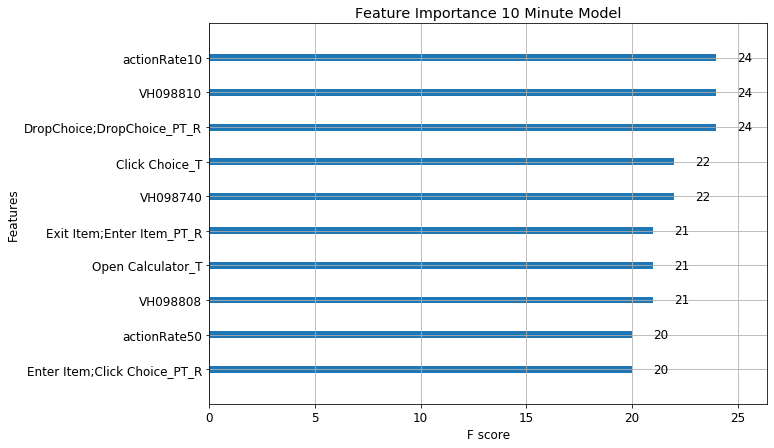

In [182]:
xgb.plot_importance(best_model,max_num_features=10, title = "Feature Importance 10 Minute Model")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig('FeatImport_10.png')


for col in dataPred.columns:
    if (not col in train.columns):
        dataPred = dataPred.drop(col, axis=1)
        
#dataPred= dataPred.drop('Target',axis=1)
dataPred = dataPred.reindex(sorted(dataPred.columns), axis=1)
print(dataPred.head())

preds = best_model.predict(dataPred)

predDF = pd.DataFrame(preds,columns=['Target'])
predDF.head()
output = pd.concat([idDF,predDF], axis = 1)
output.head()

output.to_csv('hidden10_Output_10_31_20.csv', index=False)

In [183]:
#20 Minute Model
#Read in Training Feature Data
train = pd.read_csv('../../T20_DEC11.csv')
target = 'Target'
IDcol = 'StudentID'
train = train.drop(['StudentID'],axis=1)
#remove duplicates
train = train.loc[:,~train.columns.str.endswith('.1')]

#Read in Hidden Feature Data
dataPred = pd.read_csv('../../H20_DEC11.csv')
idDF = pd.DataFrame(dataPred.StudentID)

#Convert from boolean to binary
train[target] *=1
train.head()

#Data Cleaning - Optional

#Remove more than threshold missing values
print("Removing columns with less than 10 values")
threshold = 10
train = train.dropna(axis=1,thresh=threshold)
train.head()

#In case Hidden and Training have different columns
#This is primarily for click rate for which additional columns are generated for every 10 clicks.
print("Removing columns not present in both training and hidden")
for col in train.columns:
    if (not col in dataPred.columns and not col==target):
        train = train.drop(col, axis=1)
        print(i)
        
#Seperate Target and Features
X, y = train.drop([target],axis=1),train[target]
#Sort X columns alphabetically
X = X.reindex(sorted(X.columns), axis=1)

#Split into training and validation set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

#XGBRegressor Model
xg_reg = xgb.XGBRegressor()

Removing columns with less than 10 values
Removing columns not present in both training and hidden


In [184]:
scorer = make_scorer(scoreFunc)
#kfold = StratifiedKFold(10,shuffle=True,random_state=1988)
parameters = {
    'objective':['binary:logistic'],
    'learning_rate':np.linspace(.01,.1,num=10,endpoint=True),
    'max_depth': range(3,8,1),
    'min_child_weight': range(1,7,1),
    'subsample': np.linspace(.1,1.0,num=10,endpoint=True),
    'colsample_bytree': np.linspace(.1,1.0,num=10,endpoint=True),
    'gamma':range(0,5,1),
    'n_estimators': range(20,100,10)}

while(len(X.columns) > 40):
    xgb_grid = RandomizedSearchCV(xg_reg,  parameters,n_iter=100,n_jobs = -1,scoring=scorer, cv=10, verbose=True)

    xgb_grid.fit(X, y)

    best_model = xgb_grid.best_estimator_

    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)

    featImportArr = best_model.feature_importances_
    fScores = best_model.get_booster().get_fscore()
    fScores = fScores.items()
    fScores = sorted(fScores, key=lambda x: x[1])

    fScores = fScores[int(len(fScores)*0.25):]
    keptFeatures = [i[0] for i in fScores]
    keptFeatures

    #Only keep top 50% of features
    #This is primarily for click rate for which additional columns are generated for every 10 clicks.
    print("Removing columns based on feature importance")
    for col in train.columns:
        if (not col in keptFeatures and not col==target):
            train = train.drop(col, axis=1)
            print(col)

    #Seperate Target and Features
    X, y = train.drop([target],axis=1),train[target]
    print("Number of Features Remaining: ", len(X.columns))
    #Sort X columns alphabetically
    X = X.reindex(sorted(X.columns), axis=1)

    #XGBRegressor Model
    xg_reg = xgb.XGBRegressor(importance_type = 'weight')
    
xgb_grid = RandomizedSearchCV(xg_reg,  parameters,n_iter=200,n_jobs = -1,scoring=scorer, cv=10, verbose=True)

xgb_grid.fit(X, y)

best_model = xgb_grid.best_estimator_

best_model = xgb_grid.best_estimator_

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.4min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6658616276554716
{'subsample': 0.30000000000000004, 'objective': 'binary:logistic', 'n_estimators': 50, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.04000000000000001, 'gamma': 4, 'colsample_bytree': 0.9}
Removing columns based on feature importance
Calculator Buffer
Calculator Buffer_T
Click Choice_T
DropChoice
Enter Item
Enter Item_T
Exit Item
First Text Change
Lose Focus
Move Calculator
Next
NumActs
Open Calculator
Receive Focus
Revisits
Scratchwork Mode Off
Scratchwork Mode On
VH134366
VH139047
VH139196
actionRate170
actionRate20
actionRate210
actionRate220
actionRate230
clickRate0
clickRate1
clickRate12
R0
R2
R5
R11
R15
R16
AvgCRSlope
sdQ
rangeQ
meanAction
sdAction
maxAction
rangeAction
meanCR
sdCR
maxCR
rangeCR
DirectionsObsClicks
VH356862QClicks
MCSSObsClicks
MatchMS ObsClicks
VH139047QClicks
VH098759QClicks
VH098740QClicks
VH134366QClicks
VH098812QClicks
VH139196QClicks
VH134373QClicks
meanObsClicks
sdObsClicks
maxObsClicks
minObsClicks
rangeObsClicks
meanQClicks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.3min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6952586731186632
{'subsample': 0.4, 'objective': 'binary:logistic', 'n_estimators': 30, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.04000000000000001, 'gamma': 4, 'colsample_bytree': 0.30000000000000004}
Removing columns based on feature importance
Click Progress Navigator
Click Progress Navigator_T
Close Calculator_T
Eliminate Choice
Lose Focus_T
Next_T
Receive Focus_T
VH098519
VH098740
Vertical Item Scroll
actionRate100
actionRate40
actionRate50
actionRate70
actionRate90
clickRate3
clickRate4
clickRate5
clickRate7
clickRate8
clickRate10
clickRate13
R3
R6
R7
R9
R10
R12
R13
R14
R17
minCR
VH098519QClicks
VH098808QClicks
CompositeCRObsClicks
VH098839QClicks
sdQClicks
maxQClicks
minQClicks
rangeQClicks
AboveQ0.95
Enter Item;Open Calculator_PT
Enter Item;DropChoice_PT
Enter Item;DropChoice_PT_R
Receive Focus;Lose Focus_PT
Vertical Item Scroll;Open Calculator_PT_R
Exit Item;Enter Item_PT
Lose Focus;Click Progress Navigator_PT_R
Draw;Draw_PT_R
Move Calculator;DropChoice_PT_R


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.9min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7203623353723301
{'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 20, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.09000000000000001, 'gamma': 4, 'colsample_bytree': 0.4}
Removing columns based on feature importance
CompositeCR
Draw
DropChoice_T
MatchMS 
Math Keypress
Math Keypress_T
NumQuests
StartTime
VH098839
actionRate180
actionRate30
actionRate80
clickRate2
clickRate9
R1
R4
R8
maxQ
minAction
VH098753QClicks
FillInBlankObsClicks
VH134387QClicks
BelowQ0.05
Enter Item;Click Choice_PT
Enter Item;Eliminate Choice_PT_R
Enter Item;Vertical Item Scroll;Open Calculator_PT_R
Enter Item;Click Progress Navigator_PT_R
Exit Item;Enter Item;Click Choice
Math Keypress;First Text Change_PT_R
BelowQ_Processes0.05
Click Choice;Next;Exit Item_PT_R
Calculator Buffer;Enter Item_PT_R
Vertical Item Scroll;Next_PT_R
Clear Answer;Click Choice_PT_R
min_PT_R
sd_PT
Number of Features Remaining:  60
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7310841706130116
{'subsample': 0.7000000000000001, 'objective': 'binary:logistic', 'n_estimators': 60, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.08, 'gamma': 3, 'colsample_bytree': 0.7000000000000001}
Removing columns based on feature importance
Close Calculator
Draw_T
First Text Change_T
Open Calculator_T
Scratchwork Mode Off_T
actionRate110
actionRate130
actionRate200
AverageCR
VH098810QClicks
Move Calculator;Receive Focus_PT
Move Calculator;Click Choice_PT
AboveQ_Processes0.9
Click Choice;Click Progress Navigator_PT_R
max_PT_R
Number of Features Remaining:  45
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7281256665300484
{'subsample': 0.6, 'objective': 'binary:logistic', 'n_estimators': 90, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.04000000000000001, 'gamma': 3, 'colsample_bytree': 1.0}
Removing columns based on feature importance
Move Calculator_T
VH098759
actionRate120
actionRate150
actionRate60
clickRate11
MultipleFillInBlankObsClicks
VH098783QClicks
Enter Item;Open Calculator;Calculator Buffer_PT_R
Exit Item;Enter Item_PT_R
Close Calculator;Open Calculator_PT_R
Number of Features Remaining:  34
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.1min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.736082903517217
{'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 30, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.09000000000000001, 'gamma': 4, 'colsample_bytree': 0.5}


In [185]:
#0.7593081688312175
#{'subsample': 1.0, 'objective': 'binary:logistic', 'n_estimators': 70, 'min_child_weight': 3,
# 'max_depth': 4, 'learning_rate': 0.05000000000000001, 'gamma': 3, 'colsample_bytree': 0.30000000000000004}

#OPTIONAL- Use Grid Search for more comprehensive hyperparameter tuning
#from sklearn.metrics import make_scorer
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import RandomizedSearchCV

#scorer = make_scorer(scoreFunc)
#kfold = StratifiedKFold(10,shuffle=True,random_state=1988)
#parameters = {
#    'objective':['binary:logistic'],
#    'learning_rate':[.03],
#    'max_depth': [8],
#    'min_child_weight': [3],
#    'subsample': [0.7],
#    'colsample_bytree': [0.4],
#    'gamma':[6],
#    'n_estimators': range(190,210,2)}

#xgb_grid = GridSearchCV(xg_reg,  parameters,n_jobs = -1,scoring=scorer, cv=3, verbose=True)

#xgb_grid.fit(X_train,y_train)

#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)

   Click Choice  Close Calculator;Click Choice_PT_R  \
0            16                               1.897   
1            12                               1.270   
2            13                                 NaN   
3             6                                 NaN   
4            14                               5.143   

   DropChoice;DropChoice_PT_R  Eliminate Choice_T  \
0                    0.521500              15.924   
1                    0.957667                 NaN   
2                    1.021333                 NaN   
3                    7.671800                 NaN   
4                    1.739565                 NaN   

   Enter Item;Click Choice_PT_R  \
0                     24.434600   
1                     61.547000   
2                     15.654800   
3                    120.341833   
4                     13.347636   

   Enter Item;Open Calculator;Move Calculator_PT  \
0                                         61.832   
1                                  

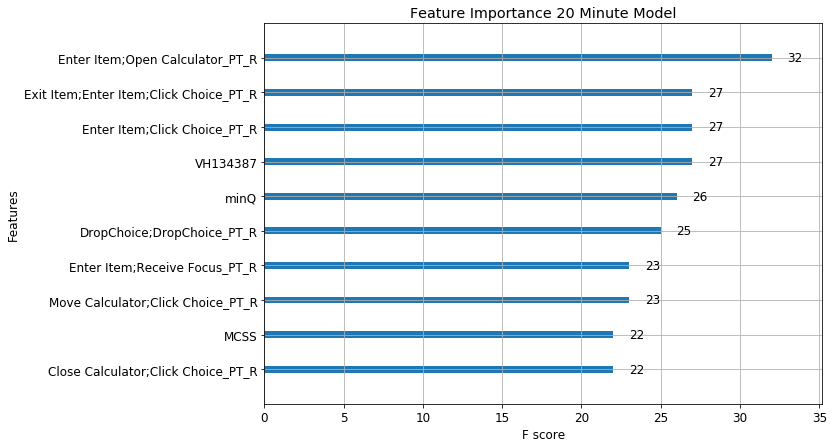

In [186]:
xgb.plot_importance(best_model,max_num_features=10, title="Feature Importance 20 Minute Model")
plt.savefig('FeatImport_20.png')


for col in dataPred.columns:
    if (not col in train.columns):
        dataPred = dataPred.drop(col, axis=1)
        
#dataPred= dataPred.drop('Target',axis=1)
dataPred = dataPred.reindex(sorted(dataPred.columns), axis=1)
print(dataPred.head())

preds = best_model.predict(dataPred)

predDF = pd.DataFrame(preds,columns=['Target'])
predDF.head()
output = pd.concat([idDF,predDF], axis = 1)
output.head()

output.to_csv('hidden20_Output_10_31_20.csv', index=False)

In [187]:
#30 Minute Model
#Read in Training Feature Data
train = pd.read_csv('../../T30_DEC11.csv')
target = 'Target'
IDcol = 'StudentID'
train = train.drop(['StudentID'],axis=1)
#remove duplicates
train = train.loc[:,~train.columns.str.endswith('.1')]

#Read in Hidden Feature Data
dataPred = pd.read_csv('../../H30_DEC11.csv')
idDF = pd.DataFrame(dataPred.StudentID)


#Convert from boolean to binary
train[target] *=1
train.head()

#Data Cleaning - Optional

#Remove more than threshold missing values
print("Removing columns with less than 10 values")
threshold = 10
train = train.dropna(axis=1,thresh=threshold)
train.head()

#In case Hidden and Training have different columns
#This is primarily for click rate for which additional columns are generated for every 10 clicks.
print("Removing columns not present in both training and hidden")
for col in train.columns:
    if (not col in dataPred.columns and not col==target):
        train = train.drop(col, axis=1)
        print(i)
        
#Seperate Target and Features
X, y = train.drop([target],axis=1),train[target]
#Sort X columns alphabetically
X = X.reindex(sorted(X.columns), axis=1)

#Split into training and validation set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

#XGBRegressor Model
xg_reg = xgb.XGBRegressor()

Removing columns with less than 10 values
Removing columns not present in both training and hidden


In [188]:
scorer = make_scorer(scoreFunc)
#kfold = StratifiedKFold(10,shuffle=True,random_state=1988)
parameters = {
    'objective':['binary:logistic'],
    'learning_rate':np.linspace(.01,.1,num=10,endpoint=True),
    'max_depth': range(3,8,1),
    'min_child_weight': range(1,7,1),
    'subsample': np.linspace(.1,1.0,num=10,endpoint=True),
    'colsample_bytree': np.linspace(.1,1.0,num=10,endpoint=True),
    'gamma':range(0,5,1),
    'n_estimators': range(20,100,10)}

while(len(X.columns) > 40):
    xgb_grid = RandomizedSearchCV(xg_reg,  parameters,n_iter=100,n_jobs = -1,scoring=scorer, cv=10, verbose=True)

    xgb_grid.fit(X, y)

    best_model = xgb_grid.best_estimator_

    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)

    featImportArr = best_model.feature_importances_
    fScores = best_model.get_booster().get_fscore()
    fScores = fScores.items()
    fScores = sorted(fScores, key=lambda x: x[1])

    fScores = fScores[int(len(fScores)*0.25):]
    keptFeatures = [i[0] for i in fScores]
    keptFeatures

    #Only keep top 50% of features
    #This is primarily for click rate for which additional columns are generated for every 10 clicks.
    print("Removing columns based on feature importance")
    for col in train.columns:
        if (not col in keptFeatures and not col==target):
            train = train.drop(col, axis=1)
            print(col)
    #Seperate Target and Features
    X, y = train.drop([target],axis=1),train[target]
    print("Number of Features Remaining: ", len(X.columns))
    #Sort X columns alphabetically
    X = X.reindex(sorted(X.columns), axis=1)

    #XGBRegressor Model
    xg_reg = xgb.XGBRegressor(importance_type = 'weight')
    
xgb_grid = RandomizedSearchCV(xg_reg,  parameters,n_iter=200,n_jobs = -1,scoring=scorer, cv=10, verbose=True)

xgb_grid.fit(X, y)

best_model = xgb_grid.best_estimator_

best_model = xgb_grid.best_estimator_

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.7min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6875342058708115
{'subsample': 0.6, 'objective': 'binary:logistic', 'n_estimators': 50, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.08, 'gamma': 4, 'colsample_bytree': 0.30000000000000004}
Removing columns based on feature importance
Calculator Buffer
Click Choice
Click Choice_T
Click Progress Navigator_T
Close Calculator
Draw
DropChoice
DropChoice_T
Enter Item
Enter Item_T
Exit Item
First Text Change
Leave Section
Leave Section_T
Lose Focus
Math Keypress
Move Calculator
Move Calculator_T
Next
NumActs
NumQuests
Open Calculator
Open Equation Editor_T
Receive Focus
Scratchwork Mode Off
Scratchwork Mode On
VH098740
Vertical Item Scroll_T
Yes
actionRate100
actionRate20
actionRate220
actionRate250
actionRate260
actionRate30
actionRate300
actionRate310
actionRate70
actionRate80
actionRate90
clickRate0
clickRate1
clickRate5
clickRate7
R0
R1
R3
R4
R5
R6
R7
R10
R11
R13
R14
R15
AverageCR
meanAction
meanCR
sdCR
maxCR
minCR
rangeCR
DirectionsObsClicks
VH356862QClicks
VH098519QClick

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.1min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7256313131376627
{'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 90, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.020000000000000004, 'gamma': 4, 'colsample_bytree': 0.30000000000000004}
Removing columns based on feature importance
Draw_T
Eliminate Choice
MatchMS 
Open Equation Editor
Revisits
VH098783
VH139047
Vertical Item Scroll
clickRate2
clickRate3
clickRate4
clickRate8
clickRate9
AvgCRSlope
sdQ
minAction
VH098810QClicks
MultipleFillInBlankObsClicks
VH134387QClicks
VH098812QClicks
VH098834QClicks
Vertical Item Scroll;Lose Focus
Vertical Item Scroll;Lose Focus_PT
Enter Item;Open Calculator
Enter Item;Click Choice
Enter Item;Receive Focus_PT_R
Enter Item;Eliminate Choice_PT
Enter Item;Next
Enter Item;Click Progress Navigator_PT
Open Calculator;Click Choice_PT_R
Receive Focus;Lose Focus
Vertical Item Scroll;Open Calculator_PT_R
Draw;Draw_PT
Lose Focus;Click Progress Navigator_PT_R
AboveQ_Processes0.9
Enter Item;Open Calculator;Move Calculator
Enter I

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.8min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7283714523536159
{'subsample': 0.4, 'objective': 'binary:logistic', 'n_estimators': 60, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.04000000000000001, 'gamma': 4, 'colsample_bytree': 0.8}
Removing columns based on feature importance
Close Calculator_T
Lose Focus_T
Scratchwork Mode Off_T
TimeLeftMessage
VH098519
VH098759
VH139196
actionRate120
actionRate170
actionRate40
clickRate10
clickRate11
clickRate12
clickRate14
R8
R9
R12
R17
maxQ
rangeQ
sdAction
rangeAction
MCSSObsClicks
VH139196QClicks
VH134373QClicks
BelowQ0.05
Enter Item;Open Calculator_PT
Move Calculator;Click Choice_PT
Exit Item;Enter Item_PT
Enter Item;Next;Exit Item_PT
Number of Features Remaining:  89
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7389845346975821
{'subsample': 0.30000000000000004, 'objective': 'binary:logistic', 'n_estimators': 60, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.06000000000000001, 'gamma': 1, 'colsample_bytree': 0.30000000000000004}
Removing columns based on feature importance
Click Progress Navigator
Math Keypress_T
Scratchwork Mode On_T
StartTime
VH098753
actionRate140
actionRate150
actionRate180
actionRate190
actionRate200
actionRate240
actionRate280
actionRate50
R2
maxAction
Enter Item;Open Calculator;Calculator Buffer_PT_R
Vertical Item Scroll;Lose Focus_PT_R
Enter Item;Scratchwork Mode On_PT_R
Exit Item;Calculator Buffer_PT_R
DropChoice;DropChoice_PT
Receive Focus;Math Keypress_PT_R
Vertical Item Scroll;Next_PT_R
mean_PT
Number of Features Remaining:  66
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.713118390951429
{'subsample': 0.2, 'objective': 'binary:logistic', 'n_estimators': 80, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.030000000000000006, 'gamma': 3, 'colsample_bytree': 0.2}
Removing columns based on feature importance
First Text Change_T
Next_T
VH098839
actionRate110
actionRate130
actionRate230
actionRate290
actionRate60
clickRate6
clickRate13
R16
Move Calculator;Receive Focus_PT
Math Keypress;First Text Change_PT_R
Click Progress Navigator;Exit Item_PT_R
Clear Answer;Click Choice_PT_R
min_PT_R
Number of Features Remaining:  50
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.1min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7484117035158597
{'subsample': 0.4, 'objective': 'binary:logistic', 'n_estimators': 70, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.04000000000000001, 'gamma': 2, 'colsample_bytree': 1.0}
Removing columns based on feature importance
Calculator Buffer_T
EOSTimeLft
Receive Focus_T
VH134366
actionRate160
actionRate210
clickRate15
clickRate17
VH098556QClicks
Enter Item;Eliminate Choice_PT_R
Receive Focus;Lose Focus_PT
Exit Item;Enter Item_PT_R
sd_PT
Number of Features Remaining:  37
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.4min finished
C:\Users\nlevi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7770504161466065
{'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 90, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.09000000000000001, 'gamma': 1, 'colsample_bytree': 0.7000000000000001}


In [189]:
#0.7842701038048573
#{'subsample': 0.6, 'objective': 'binary:logistic', 'n_estimators': 90, 'min_child_weight': 5,
# 'max_depth': 3, 'learning_rate': 0.06000000000000001, 'gamma': 2, 'colsample_bytree': 0.30000000000000004}

#OPTIONAL- Use Grid Search for more comprehensive hyperparameter tuning
#from sklearn.metrics import make_scorer
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import RandomizedSearchCV

#scorer = make_scorer(scoreFunc)
#kfold = StratifiedKFold(10,shuffle=True,random_state=1988)
#parameters = {
#    'objective':['binary:logistic'],
#    'learning_rate':[.03],
#    'max_depth': [8],
#    'min_child_weight': [3],
#    'subsample': [0.7],
#    'colsample_bytree': [0.4],
#    'gamma':[6],
#    'n_estimators': range(190,210,2)}

#xgb_grid = GridSearchCV(xg_reg,  parameters,n_jobs = -1,scoring=scorer, cv=3, verbose=True)

#xgb_grid.fit(X_train,y_train)

#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)

   BlockRev  Calculator Buffer;Enter Item_PT_R  \
0   230.327                           0.025182   
1   143.927                                NaN   
2    40.490                           0.026500   
3   132.036                                NaN   
4    90.607                           0.021167   

   Click Choice;Next;Exit Item_PT_R  Close Calculator;Click Choice_PT  \
0                          2.468929                             2.367   
1                          1.841000                           167.958   
2                          3.970750                             3.569   
3                          2.630556                             3.403   
4                          4.839500                             0.000   

   Close Calculator;Click Choice_PT_R  Close Calculator;Open Calculator_PT_R  \
0                            2.367000                                    NaN   
1                           27.993000                                  5.285   
2                   

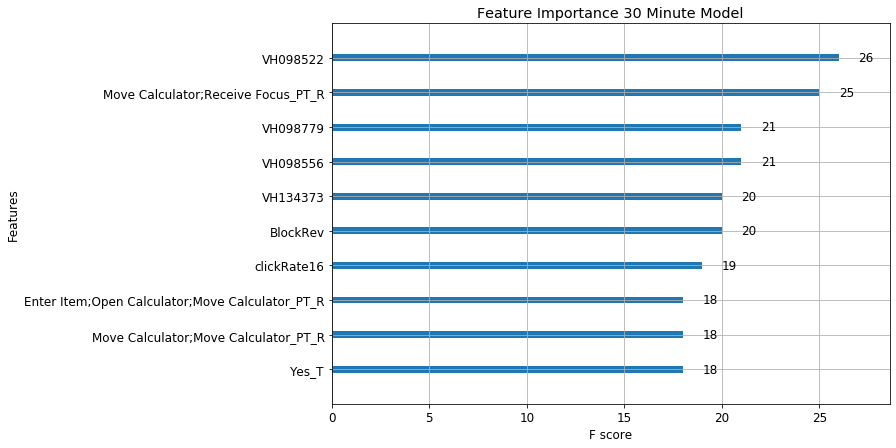

In [190]:
xgb.plot_importance(best_model,max_num_features=10,title = "Feature Importance 30 Minute Model")
plt.rcParams['figure.figsize'] = [10, 7]
plt.savefig('FeatImport_30.png')


for col in dataPred.columns:
    if (not col in train.columns):
        dataPred = dataPred.drop(col, axis=1)
        
#dataPred= dataPred.drop('Target',axis=1)
dataPred = dataPred.reindex(sorted(dataPred.columns), axis=1)
print(dataPred.head())

preds = best_model.predict(dataPred)

predDF = pd.DataFrame(preds,columns=['Target'])
predDF.head()
output = pd.concat([idDF,predDF], axis = 1)
output.head()

output.to_csv('hidden30_Output_10_31_20.csv', index=False)

In [192]:
#Read in predictions and combine them
hidden10 = pd.read_csv('hidden10_Output_10_31_20.csv')
hidden20 = pd.read_csv('hidden20_Output_10_31_20.csv')
hidden30 = pd.read_csv('hidden30_Output_10_31_20.csv')
frames = [hidden10,hidden20,hidden30]
result = pd.concat(frames)

#Sort by StudentID to match test
hidden10 = hidden10.sort_values(by='StudentID')
hidden20 = hidden20.sort_values(by='StudentID')
hidden30 = hidden30.sort_values(by='StudentID')
result = result.sort_values(by=['StudentID'])


list_10_ids = hidden10['StudentID'].to_list()
list_20_ids = hidden20['StudentID'].to_list()
list_30_ids = hidden30['StudentID'].to_list()

################################################################################################################################
#Public Leaderboard Scoring

#Read in public leaderboard test
publicTargets = pd.read_csv('../EvaluationData/hidden_leaderboard.csv')

#filter for public leaderboard ids
list_of_ids = publicTargets['STUDENTID'].to_list()

public10Preds = hidden10[hidden10.StudentID.isin(list_of_ids)]
public10Targets = publicTargets[publicTargets.STUDENTID.isin(list_10_ids)]

public20Preds = hidden20[hidden20.StudentID.isin(list_of_ids)]
public20Targets = publicTargets[publicTargets.STUDENTID.isin(list_20_ids)]

public30Preds = hidden30[hidden30.StudentID.isin(list_of_ids)]
public30Targets = publicTargets[publicTargets.STUDENTID.isin(list_30_ids)]

publicPreds = result[result.StudentID.isin(list_of_ids)]

#Extract just the target values for scoring
publicPredsArr = publicPreds.loc[:,'Target']
publicTarArr = publicTargets.loc[:,'EfficientlyCompletedBlockB']
public10PredsArr = public10Preds.loc[:,'Target']
public10TarArr = public10Targets.loc[:,'EfficientlyCompletedBlockB']
public20PredsArr = public20Preds.loc[:,'Target']
public20TarArr = public20Targets.loc[:,'EfficientlyCompletedBlockB']
public30PredsArr = public30Preds.loc[:,'Target']
public30TarArr = public30Targets.loc[:,'EfficientlyCompletedBlockB']

print("Scoring on Public Leaderboard 10: \n")
leaderBoard = scoreFunc(public10TarArr, public10PredsArr)
print("Total: ", leaderBoard)

print("\nScoring on Public Leaderboard 20: \n")
leaderBoard = scoreFunc(public20TarArr, public20PredsArr)
print("Total: ", leaderBoard)

print("\nScoring on Public Leaderboard 30: \n")
leaderBoard = scoreFunc(public30TarArr, public30PredsArr)
print("Total: ", leaderBoard)

print("\nTotal Scoring on Public Leaderboard: \n")
hiddenLeaderBoard = scoreFunc(publicTarArr,publicPredsArr)
print("\nTotal: ", hiddenLeaderBoard)


################################################################################################################################
#Final Leaderboard Scoring
finalTargets = pd.read_csv('../EvaluationData/hidden_test.csv')


#filter for final leaderboard ids
list_of_ids = finalTargets['STUDENTID'].to_list()


final10Preds = hidden10[hidden10.StudentID.isin(list_of_ids)]
final10Targets = finalTargets[finalTargets.STUDENTID.isin(list_10_ids)]

final20Preds = hidden20[hidden20.StudentID.isin(list_of_ids)]
final20Targets = finalTargets[finalTargets.STUDENTID.isin(list_20_ids)]

final30Preds = hidden30[hidden30.StudentID.isin(list_of_ids)]
final30Targets = finalTargets[finalTargets.STUDENTID.isin(list_30_ids)]

finalPreds = result[result.StudentID.isin(list_of_ids)]

#Extract just the target values for scoring
final10PredsArr = final10Preds.loc[:,'Target']
final10TarArr = final10Targets.loc[:,'EfficientlyCompletedBlockB']
final20PredsArr = final20Preds.loc[:,'Target']
final20TarArr = final20Targets.loc[:,'EfficientlyCompletedBlockB']
final30PredsArr = final30Preds.loc[:,'Target']
final30TarArr = final30Targets.loc[:,'EfficientlyCompletedBlockB']
finalPredsArr = finalPreds.loc[:,'Target']
finalTarArr = finalTargets.loc[:,'EfficientlyCompletedBlockB']

print("\nScoring on final Leaderboard 10: \n")
leaderBoard = scoreFunc(final10TarArr, final10PredsArr)
print("Total: ", leaderBoard)

print("\nScoring on final Leaderboard 20: \n")
leaderBoard = scoreFunc(final20TarArr, final20PredsArr)
print("Total: ", leaderBoard)

print("\nScoring on final Leaderboard 30: \n")
leaderBoard = scoreFunc(final30TarArr, final30PredsArr)
print("Total: ", leaderBoard)

print("\nTotal Scoring on final Leaderboard: \n")
finalLeaderBoard = scoreFunc(finalTarArr, finalPredsArr)
print("Total: ", finalLeaderBoard)


################################################################################################################################
#Final Leaderboard Scoring
combinedTargets = pd.concat([finalTargets,publicTargets])

#Sort by Student ID to ensure same order
combinedTargets = combinedTargets.sort_values(by='STUDENTID')
result = result.sort_values(by='StudentID')

combined10Targets = combinedTargets[combinedTargets.STUDENTID.isin(list_10_ids)]

combined20Targets = combinedTargets[combinedTargets.STUDENTID.isin(list_20_ids)]

combined30Targets = combinedTargets[combinedTargets.STUDENTID.isin(list_30_ids)]




#Extract just the target values for scoring
combined10PredsArr = hidden10.loc[:,'Target']
final10TarArr = combined10Targets.loc[:,'EfficientlyCompletedBlockB']
combined20PredsArr = hidden20.loc[:,'Target']
final20TarArr = combined20Targets.loc[:,'EfficientlyCompletedBlockB']
combined30PredsArr = hidden30.loc[:,'Target']
final30TarArr = combined30Targets.loc[:,'EfficientlyCompletedBlockB']

resultPreds = result.loc[:,'Target']
publicTarArr = combinedTargets.loc[:,'EfficientlyCompletedBlockB']

print("\nScoring on Combined Leaderboard 10: \n")
leaderBoard = scoreFunc(final10TarArr, combined10PredsArr)
print("Total: ", leaderBoard)

print("\nScoring on Combined Leaderboard 20: \n")
leaderBoard = scoreFunc(final20TarArr, combined20PredsArr)
print("Total: ", leaderBoard)

print("\nScoring on Combined Leaderboard 30: \n")
leaderBoard = scoreFunc(final30TarArr, combined30PredsArr)
print("Total: ", leaderBoard)

print("\nTotal Combined Scoring: \n")
combinedLeaderBoard = scoreFunc(publicTarArr, resultPreds)
print("Total: ", combinedLeaderBoard)

print("\nCombined Leaderboards: ", (finalLeaderBoard + hiddenLeaderBoard)/2)

Scoring on Public Leaderboard 10: 

AUC: 0.6298287534846675
AdjustedAUC: 0.259657506969335
Kappa: 0.1985926505082095
AdjustedKappa: 0.1985926505082095
Total:  0.4582501574775445

Scoring on Public Leaderboard 20: 

AUC: 0.6229589804858622
AdjustedAUC: 0.24591796097172436
Kappa: 0.16878412715575508
AdjustedKappa: 0.16878412715575508
Total:  0.41470208812747944

Scoring on Public Leaderboard 30: 

AUC: 0.6770211071286341
AdjustedAUC: 0.3540422142572681
Kappa: 0.22344455399304652
AdjustedKappa: 0.22344455399304652
Total:  0.5774867682503146

Total Scoring on Public Leaderboard: 

AUC: 0.6434687375547591
AdjustedAUC: 0.28693747510951817
Kappa: 0.19732059768581112
AdjustedKappa: 0.19732059768581112

Total:  0.4842580727953293

Scoring on final Leaderboard 10: 

AUC: 0.6540125885129819
AdjustedAUC: 0.3080251770259639
Kappa: 0.2565121874673083
AdjustedKappa: 0.2565121874673083
Total:  0.5645373644932722

Scoring on final Leaderboard 20: 

AUC: 0.6917781274586939
AdjustedAUC: 0.383556254917387